In [1]:
try: 
  from mc_lib.rndm import RndmWrapper
except ImportError:
  !pip install git+https://github.com/ev-br/mc_lib.git@master
  pass

  Cloning https://github.com/ev-br/mc_lib.git (to revision master) to /tmp/pip-req-build-v6c4n2dc
  Running command git clone -q https://github.com/ev-br/mc_lib.git /tmp/pip-req-build-v6c4n2dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached meson-0.59.2-py3-none-any.whl
  Using cached ninja-1.10.2.3-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (108 kB)
  Created wheel for mc-lib: filename=mc_lib-0.3-cp37-cp37m-any.whl size=729880 sha256=452227b5d45bef09a8f048a42943a75b659a78857c72dd295d971b251449b585
  Stored in directory: /tmp/pip-ephem-wheel-cache-f7ll4y0o/wheels/9e/cd/91/742e9309e30c182d817ad95e330ab5a51185b9c205a4a38d85
Successfully built mc-lib


In [2]:
try: 
  from _common import tabulate_neighbors
except ImportError:
  from google.colab import files
  uploaded = files.upload()
  pass

Saving _common.py to _common.py
Saving _square.py to _square.py


In [3]:
%load_ext cython

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
%%cython --cplus
import cython
import numpy as np
cimport numpy as np
from libc.time cimport time
from libc.math cimport exp
from mc_lib.rndm cimport RndmWrapper
from _common import tabulate_neighbors
from mc_lib.observable cimport RealObservable

@cython.boundscheck(False)
@cython.wraparound(False)
cdef np.ndarray initState(int linear_size, RndmWrapper rndm):
    cdef np.ndarray[np.int_t, ndim=2,negative_indices=False,
                                                  mode='c'] lattice = np.zeros([linear_size, linear_size], dtype=int)
    cdef int i = 0
    cdef int j = 0
    for i in range(linear_size):
        for j in range(linear_size):
            lattice[i,j] = 1 if rndm.uniform() > 0.5 else -1
    return lattice

@cython.boundscheck(False)
@cython.wraparound(False)
cdef np.ndarray mcmove(np.ndarray config,double beta,int L,
                                                         np.ndarray [np.int_t, ndim=2,negative_indices=False] ngb,
                                                                                                              RndmWrapper rndm):
    """
    One Monte-Carlo step

    params:
        config: Current configuration of lattice
        beta:   Inversed temperature of current configuration
        L:      Linear size 'L' of lattice
        ngb:    Array of neigbours
    return:
    """
    cdef:
        # Choose a random spin
        double foo = rndm.uniform()
        int i = int(foo*(L*L)) //L
        int j = int(foo*(L*L)) %L
        # current spin: sigma_i
        int site =  config[i, j]
        #  count neighbours: up, down, left, right
        #  nb = sum( sigma_j )
        double dE = 0
    for n in range(1,5):
        dE += site * config[ngb[i*L + j, n] //L, ngb[i*L + j, n] % L]
    cdef double ratio = exp(-2 * dE * beta)
    if rndm.uniform() > ratio:
        config[i, j] = site
    else:
        site *= -1
        config[i, j] = site
    return



@cython.boundscheck(False)  # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire functio
cdef double calcEnergy(np.ndarray config, int L, ngb):
    # config = lattice configuration on current step
    # L - size of lattice
    cdef:
        int i = 0
        int j = 0
        int site = 0
        double energy = 0
    for i in range(L):
        for j in range(L):
            site = config[i, j]
            for n in range(1,5):
                one_ngb = config[ngb[i*L + j, n] //L, ngb[i*L + j, n] % L]
                energy += -1 * site * one_ngb
    return energy / 2.


@cython.boundscheck(False)  # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def IsingSimulate(L, T, sweeps, int seed = np.random.randint(0,1000), int rseed = 1234):
    """
        L - linear_size
        T - One temperature point
        Sweeps - number of L^2 Metropolis Monte-Karlo steps

    """
    cdef RndmWrapper rndm = RndmWrapper((rseed, seed))
    cdef RealObservable e = RealObservable()
    cdef:
        float beta = 1.0 / T  # inversed temperature
        int sweep = 0
        int steps_per_sweep = L * L
        int num_therm = int(10* L * L) # ?10?
        int i = 0


    cdef:
        list configs = []
        np.ndarray [np.int_t, ndim=2,negative_indices=False] ngb = tabulate_neighbors(L, kind='sq')
        np.ndarray[np.int_t, ndim = 2, negative_indices = False, mode = 'c'] config
    config = initState(L, rndm)

    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            mcmove(config, beta, L, ngb, rndm)
    enes = np.zeros(sweeps)

    for sweep in range(sweeps):
        for i in range(steps_per_sweep):
            mcmove(config, beta, L, ngb, rndm)

        Et = calcEnergy(config, L, ngb)
        e.add_measurement(Et)
        enes[sweep] = Et

    error = e.errorbar
    mean_energ = e.mean
    converg = e.is_converged
    return enes, mean_energ, error,converg


In [17]:
mean_energ_arr = []
err_energ_arr = []
energ_arr = []
converg_arr = []

Temps = np.linspace(0.5, 7, 40)
for t in Temps:
    energ, mean_energ, err_energ, converg = IsingSimulate(4, t, 10000)
    energ_arr.append(energ)
    mean_energ_arr.append(mean_energ)
    err_energ_arr.append(err_energ)
    converg_arr.append(converg)
energ_arr = np.array(energ_arr)
mean_energ_arr = np.array(mean_energ_arr)
err_energ_arr = np.array(err_energ_arr)
converg_arr = np.array(converg_arr)


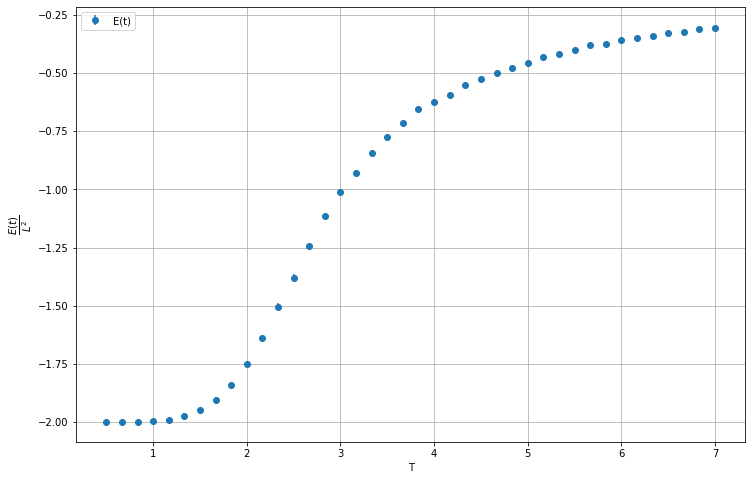

In [18]:
plt.figure(figsize=(12,8))
plt.errorbar(Temps, mean_energ_arr / 16, err_energ_arr / 16,   marker = "o", linestyle="None", label='E(t)')
plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\dfrac{E(t)}{L^2}$")
plt.grid()